# **Algorithms for massive datasets and Statistical Methods for Machine Learning  experimental project**

This notebook is runned on colab with the help of the GPU made available by Google.

## 1. Preprocessing

In [ ]:
from tqdm import tqdm
import pickle
import math
import random
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras import layers
from keras.callbacks import EarlyStopping
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing import image
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
from sklearn.metrics import f1_score, roc_auc_score, roc_curve, auc
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
from tensorflow.keras.layers import Dense, Dropout, Flatten, Activation, Conv2D, MaxPooling2D, BatchNormalization, ZeroPadding2D

In [ ]:
img_size = (100, 100)
batch_size = 32
input_shape = (100,100,3)

In [ ]:
seed = 42
import os
os.environ['PYTHONHASHSEED']=str(seed)
import random
random.seed(seed)
np.random.seed(seed)
tf.random.set_seed(seed)
from keras import backend as K
session_conf = tf.compat.v1.ConfigProto(intra_op_parallelism_threads=1, inter_op_parallelism_threads=1)
sess = tf.compat.v1.Session(graph=tf.compat.v1.get_default_graph(), config=session_conf)
tf.compat.v1.keras.backend.set_session(sess)

How to get kaggle API token needed to download the dataset:
1. Go to your account, Scroll to API section and Click Expire API Token to remove previous tokens

2. Click on Create New API Token - It will download kaggle.json file on your machine.

3. Take kaggle.json and put into /content/drive/MyDrive/


In [ ]:
#to mount the google fold "drive" in which save kaggle.json
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#to be performed only once to download and decompress the dataset
! pip install -q kaggle
! mkdir ~/.kaggle
! cp /content/drive/MyDrive/kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json
! kaggle datasets download jeffheaton/glasses-or-no-glasses
! unzip glasses-or-no-glasses


Output streaming troncato alle ultime 5000 righe.
  inflating: faces-spring-2020/faces-spring-2020/face-1000.png  
  inflating: faces-spring-2020/faces-spring-2020/face-1001.png  
  inflating: faces-spring-2020/faces-spring-2020/face-1002.png  
  inflating: faces-spring-2020/faces-spring-2020/face-1003.png  
  inflating: faces-spring-2020/faces-spring-2020/face-1004.png  
  inflating: faces-spring-2020/faces-spring-2020/face-1005.png  
  inflating: faces-spring-2020/faces-spring-2020/face-1006.png  
  inflating: faces-spring-2020/faces-spring-2020/face-1007.png  
  inflating: faces-spring-2020/faces-spring-2020/face-1008.png  
  inflating: faces-spring-2020/faces-spring-2020/face-1009.png  
  inflating: faces-spring-2020/faces-spring-2020/face-101.png  
  inflating: faces-spring-2020/faces-spring-2020/face-1010.png  
  inflating: faces-spring-2020/faces-spring-2020/face-1011.png  
  inflating: faces-spring-2020/faces-spring-2020/face-1012.png  
  inflating: faces-spring-2020/faces-spri

In [ ]:
#to be performed only once
train = pd.read_csv('/content/train.csv', usecols=['id', 'glasses'])
test = pd.read_csv('/content/test.csv', usecols=['id'])

### Utility functions

In [ ]:
def save_data(data):
  pickle_out = open("/content/drive/MyDrive/"+data[0]+".pickle","wb")
  pickle.dump(data[1], pickle_out)
  pickle_out.close()

In [ ]:
def open_data(data):
  pickle_in = open("/content/drive/MyDrive/"+data+".pickle","rb")
  x = pickle.load(pickle_in)
  pickle_in.close()
  return x

### Preprocessing of the dataset

In [ ]:
train_dataset = []
for i in tqdm(range(train.shape[0])):
    img = image.load_img('faces-spring-2020/faces-spring-2020/face-'+train['id'][i].astype('str')+'.png', target_size=img_size, color_mode="rgb", grayscale=False)
    img = image.img_to_array(img)/255.
    train_dataset.append((img, train['glasses'][i]))
train_dataset = np.array(train_dataset)

100%|██████████| 4500/4500 [03:56<00:00, 19.05it/s]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  # This is added back by InteractiveShellApp.init_path()


In [ ]:
test_images = []
for i in tqdm(range(test.shape[0])):
    img = image.load_img('faces-spring-2020/faces-spring-2020/face-'+test['id'][i].astype('str')+'.png', target_size=img_size, color_mode="rgb", grayscale=False)
    img = image.img_to_array(img)/255.
    test_images.append(img)

test_images = np.array(test_images)

100%|██████████| 500/500 [00:26<00:00, 18.54it/s]


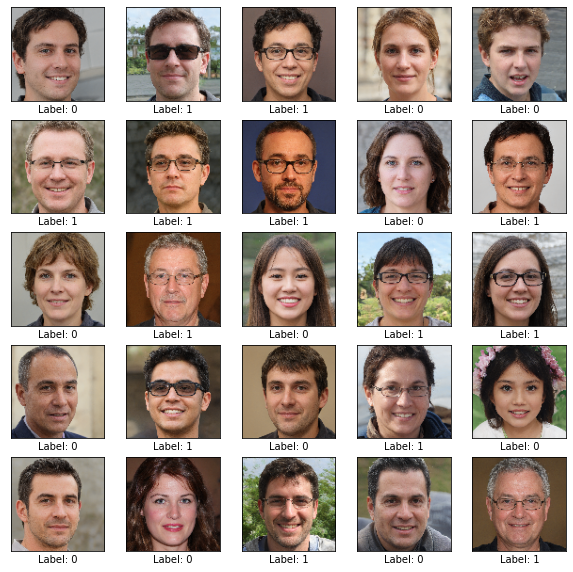

In [ ]:
plt.figure(figsize=(10,10))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(train_dataset[i][0])
    plt.xlabel(f'Label: {train_dataset[i][1]}')
plt.show()


## 1.1. See whether classes are balanced

In [ ]:
glasses = [(x,y) for (x,y) in train_dataset if y==1]
no_glasses = [(x,y) for (x,y) in train_dataset if y==0]

print(f"So we have {round(len(glasses)/len(train_dataset)*100, 2)}% of images labeled as glasses\
 and {round(len(no_glasses)/len(train_dataset)*100,2)}% labeled as no glasses.")

So we have 63.47% of images labeled as glasses and 36.53% labeled as no glasses.


Given the fact that classes are unbalanced we decide to balance the dataset with data augmentation by oversampling the class which has fewer labels (no_glasses).


### 1.1.2. Oversampling class 'no_glasses'

In [ ]:
data_augmentation = tf.keras.Sequential([
  layers.experimental.preprocessing.RandomFlip("horizontal"),
  layers.experimental.preprocessing.RandomRotation(0.1),
  layers.experimental.preprocessing.RandomContrast(0.2)
])

random.shuffle(no_glasses)
no_glasses_augmented = [(data_augmentation(img),label) for (img,label) in no_glasses[:len(glasses)-len(no_glasses)]]

In [ ]:
no_glasses = no_glasses_augmented+no_glasses
len(no_glasses)

2856

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


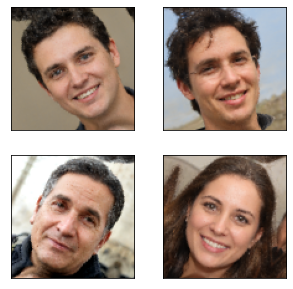

In [ ]:
plt.figure(figsize=(5,5))
for i in range(4):
    plt.subplot(2,2,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(no_glasses_augmented[i][0])
plt.show()

In [ ]:
oversampled_train = no_glasses+glasses
random.shuffle(oversampled_train)
len(oversampled_train)

5712

In [ ]:
def divide_samples_labels(train):
  X = np.array([x for (x,y) in train])
  y = np.array([y for (x,y) in train])
  return (X,y)

# 2. CNNs

In the following function we perform some passages in order to get better performance. `Dataset.cache` keeps the images in memory after they're loaded off disk during the first epoch. This will ensure the dataset does not become a bottleneck while training the model. `Dataset.prefetch` fetch next batches while training on the current one. We will consider each time a minibatch of 32 examples.

In [ ]:
AUTOTUNE = tf.data.AUTOTUNE

def get_dataset_for_CNN(imgs, labels, batch_size):
  dataset = tf.data.Dataset.from_tensor_slices((imgs, labels))
  dataset = dataset.cache()
  dataset = dataset.shuffle(len(imgs), seed, True)
  dataset = dataset.batch(batch_size = batch_size , drop_remainder=True)
  dataset = dataset.prefetch(AUTOTUNE)
  return dataset


Firstly we try several architectures in order to find the most promising, and then perform a model selection on one parameter at a time. Next, we compare the found solution with a Grid Search in order to find a suitable number of filters and number of blocks.

In [ ]:
def lr_decay(epoch):
  return 0.01 * math.pow(0.6, epoch)

lr_decay_callback = tf.keras.callbacks.LearningRateScheduler(lr_decay, verbose=False)

## 2.1.   In this section we perform experiments on networks with different architectures for the unbalanced dataset.

In [ ]:
X, y = divide_samples_labels(train_dataset)

In [ ]:
X_base_train, X_base_test, y_base_train, y_base_test = train_test_split(X, y, test_size=0.2, random_state=seed)
X_base_train, X_base_validation, y_base_train, y_base_validation = train_test_split(X_base_train, y_base_train, test_size=0.2, random_state=seed)

ds_base_train = get_dataset_for_CNN(X_base_train, y_base_train, batch_size)
ds_base_validation = get_dataset_for_CNN(X_base_validation, y_base_validation, batch_size)
ds_base_test = get_dataset_for_CNN(X_base_test, y_base_test, batch_size)

### Base Architecture

In [ ]:
def get_cnn_base(input_shape=input_shape):
    net = Sequential()
    net.add(Conv2D(16, 3, activation='relu', input_shape=input_shape))
    net.add(MaxPooling2D())
    net.add(Conv2D(32, 5, 2, activation='relu'))
    net.add(MaxPooling2D())

    net.add(Flatten())
    net.add(Dense(64, activation='relu'))
    net.add(Dense(1, activation='sigmoid'))

    net.compile(loss=tf.keras.losses.BinaryCrossentropy(), optimizer=tf.keras.optimizers.Adam(), metrics=['accuracy'])
    return net

base = get_cnn_base()

hist_base = base.fit(x=ds_base_train,
              epochs=20,
              validation_data=ds_base_validation,
              verbose=1, 
              callbacks=[lr_decay_callback])
hist_base_evaluate = base.evaluate(x=ds_base_test)

Epoch 1/20
90/90 [==============================] - 2s 16ms/step - loss: 0.7764 - accuracy: 0.7056 - val_loss: 0.3512 - val_accuracy: 0.8594 - lr: 0.0100
Epoch 2/20
90/90 [==============================] - 1s 14ms/step - loss: 0.3482 - accuracy: 0.8448 - val_loss: 0.2860 - val_accuracy: 0.8920 - lr: 0.0060
Epoch 3/20
90/90 [==============================] - 1s 13ms/step - loss: 0.3167 - accuracy: 0.8635 - val_loss: 0.2690 - val_accuracy: 0.9020 - lr: 0.0036
Epoch 4/20
90/90 [==============================] - 1s 14ms/step - loss: 0.2945 - accuracy: 0.8774 - val_loss: 0.2674 - val_accuracy: 0.8906 - lr: 0.0022
Epoch 5/20
90/90 [==============================] - 1s 14ms/step - loss: 0.2833 - accuracy: 0.8795 - val_loss: 0.2602 - val_accuracy: 0.8963 - lr: 0.0013
Epoch 6/20
90/90 [==============================] - 1s 14ms/step - loss: 0.2769 - accuracy: 0.8809 - val_loss: 0.2585 - val_accuracy: 0.8935 - lr: 7.7760e-04
Epoch 7/20
90/90 [==============================] - 1s 13ms/step - loss:

In [ ]:
base.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_6 (Conv2D)           (None, 98, 98, 16)        448       
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 49, 49, 16)       0         
 2D)                                                             
                                                                 
 conv2d_7 (Conv2D)           (None, 23, 23, 32)        12832     
                                                                 
 max_pooling2d_7 (MaxPooling  (None, 11, 11, 32)       0         
 2D)                                                             
                                                                 
 flatten_3 (Flatten)         (None, 3872)              0         
                                                                 
 dense_6 (Dense)             (None, 64)               

### Double Convolutional layers Architecture



In [ ]:
def get_cnn_double_conv(input_shape=input_shape):
    net = Sequential()

    net.add(Conv2D(16, 3, input_shape=input_shape))
    net.add(Activation('relu'))
    net.add(Conv2D(16, 3, ))
    net.add(Activation('relu'))
    net.add(MaxPooling2D((2,2), strides=(2,2)))

    net.add(Conv2D(32, 5, 2))
    net.add(Activation('relu'))
    net.add(Conv2D(32, 5, 2))
    net.add(Activation('relu'))
    net.add(Conv2D(32, 5, 2))
    net.add(Activation('relu'))
    net.add(MaxPooling2D((2,2), strides=(2,2)))

    net.add(Flatten())
    net.add(Dense(64))
    net.add(Activation('relu'))
    net.add(Dropout(0.5))
    net.add(Dense(64))
    net.add(Activation('relu'))
    net.add(Dropout(0.5))
    net.add(Dense(1, activation='sigmoid'))

    net.compile(loss=tf.keras.losses.BinaryCrossentropy(), optimizer=tf.keras.optimizers.Adam(), metrics=['accuracy'])
    return net

double_conv = get_cnn_double_conv()
hist_double_conv = double_conv.fit(x=ds_base_train,
              epochs=20,
              validation_data=ds_base_validation,
              verbose=1,
              callbacks=[lr_decay_callback])
hist_double_conv_evaluate = double_conv.evaluate(x=ds_base_test)

Epoch 1/20
90/90 [==============================] - 4s 30ms/step - loss: 0.6602 - accuracy: 0.6302 - val_loss: 0.6662 - val_accuracy: 0.6222 - lr: 0.0100
Epoch 2/20
90/90 [==============================] - 2s 27ms/step - loss: 0.6587 - accuracy: 0.6368 - val_loss: 0.6672 - val_accuracy: 0.6136 - lr: 0.0060
Epoch 3/20
90/90 [==============================] - 2s 27ms/step - loss: 0.6564 - accuracy: 0.6368 - val_loss: 0.6666 - val_accuracy: 0.6151 - lr: 0.0036
Epoch 4/20
90/90 [==============================] - 3s 28ms/step - loss: 0.6582 - accuracy: 0.6368 - val_loss: 0.6660 - val_accuracy: 0.6165 - lr: 0.0022
Epoch 5/20
90/90 [==============================] - 2s 27ms/step - loss: 0.6571 - accuracy: 0.6368 - val_loss: 0.6624 - val_accuracy: 0.6236 - lr: 0.0013
Epoch 6/20
90/90 [==============================] - 2s 27ms/step - loss: 0.6554 - accuracy: 0.6368 - val_loss: 0.6673 - val_accuracy: 0.6151 - lr: 7.7760e-04
Epoch 7/20
90/90 [==============================] - 2s 28ms/step - loss:

In [ ]:
double_conv.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_8 (Conv2D)           (None, 98, 98, 16)        448       
                                                                 
 activation (Activation)     (None, 98, 98, 16)        0         
                                                                 
 conv2d_9 (Conv2D)           (None, 96, 96, 16)        2320      
                                                                 
 activation_1 (Activation)   (None, 96, 96, 16)        0         
                                                                 
 max_pooling2d_8 (MaxPooling  (None, 48, 48, 16)       0         
 2D)                                                             
                                                                 
 conv2d_10 (Conv2D)          (None, 22, 22, 32)        12832     
                                                      

### Batch Normalization and Dropout Achitecture

In [ ]:
def get_cnn_batch_norm(input_shape=(100,100,3)):
    net = Sequential()
    
    net.add(Conv2D(16, kernel_size=3, padding='same', input_shape=input_shape))
    net.add(BatchNormalization(center=True, scale=False))
    net.add(Activation('relu'))
    net.add(Conv2D(16, kernel_size=3, padding='same'))
    net.add(BatchNormalization(center=True, scale=False))
    net.add(Activation('relu'))
    net.add(MaxPooling2D())

    net.add(Conv2D(32, kernel_size=5, padding='same', strides=2))
    net.add(BatchNormalization(center=True, scale=False))
    net.add(Activation('relu'))
    net.add(Conv2D(32, kernel_size=5, padding='same', strides=2))
    net.add(BatchNormalization(center=True, scale=False))
    net.add(Activation('relu'))
    net.add(MaxPooling2D())

    net.add(Flatten())
    net.add(Dense(64))
    net.add(BatchNormalization(center=True, scale=False))
    net.add(Activation('relu'))
    net.add(Dropout(0.5))
    net.add(Dense(1))
    net.add(Activation('sigmoid'))

    net.compile(loss=tf.keras.losses.BinaryCrossentropy(), optimizer=tf.keras.optimizers.Adam(), metrics=['accuracy'])
    return net

batch_norm = get_cnn_batch_norm()
hist_batch_norm = batch_norm.fit(x=ds_base_train,
              epochs=20,
              validation_data=ds_base_validation,
              verbose=1, 
              callbacks=[lr_decay_callback])
hist_batch_norm_evaluate = batch_norm.evaluate(x=ds_base_test)

Epoch 1/20
90/90 [==============================] - 13s 40ms/step - loss: 0.4169 - accuracy: 0.8132 - val_loss: 0.9807 - val_accuracy: 0.6222 - lr: 0.0100
Epoch 2/20
90/90 [==============================] - 3s 37ms/step - loss: 0.3183 - accuracy: 0.8694 - val_loss: 0.4588 - val_accuracy: 0.8778 - lr: 0.0060
Epoch 3/20
90/90 [==============================] - 3s 36ms/step - loss: 0.2863 - accuracy: 0.8771 - val_loss: 0.4520 - val_accuracy: 0.8906 - lr: 0.0036
Epoch 4/20
90/90 [==============================] - 3s 36ms/step - loss: 0.2516 - accuracy: 0.8941 - val_loss: 0.2924 - val_accuracy: 0.9077 - lr: 0.0022
Epoch 5/20
90/90 [==============================] - 3s 35ms/step - loss: 0.2220 - accuracy: 0.9101 - val_loss: 0.4077 - val_accuracy: 0.7656 - lr: 0.0013
Epoch 6/20
90/90 [==============================] - 3s 36ms/step - loss: 0.1959 - accuracy: 0.9177 - val_loss: 0.2463 - val_accuracy: 0.9162 - lr: 7.7760e-04
Epoch 7/20
90/90 [==============================] - 3s 36ms/step - loss

In [ ]:
batch_norm.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_17 (Conv2D)          (None, 100, 100, 16)      448       
                                                                 
 batch_normalization_5 (Batc  (None, 100, 100, 16)     48        
 hNormalization)                                                 
                                                                 
 activation_13 (Activation)  (None, 100, 100, 16)      0         
                                                                 
 conv2d_18 (Conv2D)          (None, 100, 100, 16)      2320      
                                                                 
 batch_normalization_6 (Batc  (None, 100, 100, 16)     48        
 hNormalization)                                                 
                                                                 
 activation_14 (Activation)  (None, 100, 100, 16)     

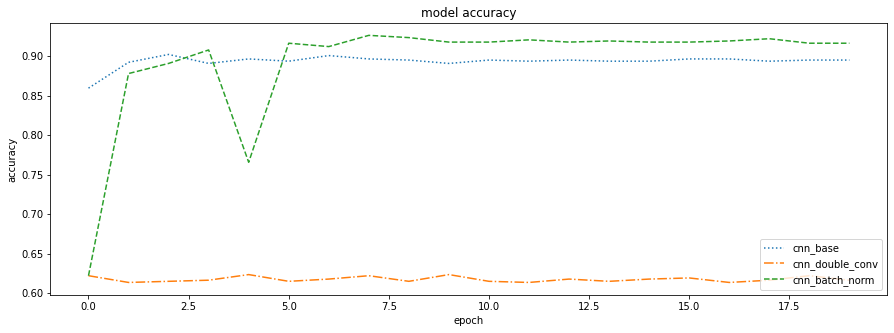

In [ ]:
names = ["cnn_base","cnn_double_conv","cnn_batch_norm"]
styles=[':','-.','--','-']

plt.figure(figsize=(15,5))
plt.plot(hist_base.history['val_accuracy'], linestyle=styles[0])
plt.plot(hist_double_conv.history['val_accuracy'], linestyle=styles[1])
plt.plot(hist_batch_norm.history['val_accuracy'], linestyle=styles[2])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(names, loc='lower right')
plt.show()

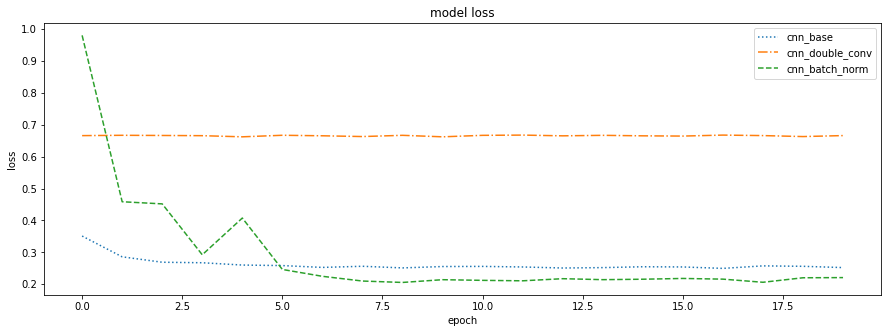

In [ ]:
names = ["cnn_base","cnn_double_conv","cnn_batch_norm"]
styles=[':','-.','--','-',':','-.','--','-',':','-.','--','-']


plt.figure(figsize=(15,5))
plt.plot(hist_base.history['val_loss'], linestyle=styles[0])
plt.plot(hist_double_conv.history['val_loss'], linestyle=styles[1])
plt.plot(hist_batch_norm.history['val_loss'], linestyle=styles[2])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(names, loc='upper right')
plt.show()

## Parameters tuning with stratified cross validation for unbalanced dataset

In [ ]:
def get_cnn_batch_norm_CV(input_shape=input_shape, conv_filters=16, neurons=64, blocks=2, dropout=0.5):
    net = Sequential()
    
    net.add(Conv2D(conv_filters, kernel_size=3, padding='same', input_shape=input_shape))
    net.add(BatchNormalization(center=True, scale=False))
    net.add(Activation('relu'))
    net.add(Conv2D(conv_filters, kernel_size=3, padding='same'))
    net.add(BatchNormalization(center=True, scale=False))
    net.add(Activation('relu'))
    net.add(MaxPooling2D())

    if blocks > 1:
      net.add(Conv2D(conv_filters*2, kernel_size=5, padding='same', strides=2))
      net.add(BatchNormalization(center=True, scale=False))
      net.add(Activation('relu'))
      net.add(Conv2D(conv_filters*2, kernel_size=5, padding='same', strides=2))
      net.add(BatchNormalization(center=True, scale=False))
      net.add(Activation('relu'))
      net.add(MaxPooling2D())
    
    if blocks > 2:
      net.add(Conv2D(conv_filters*3, kernel_size=5, padding='same', strides=2))
      net.add(BatchNormalization(center=True, scale=False))
      net.add(Activation('relu'))
      net.add(Conv2D(conv_filters*3, kernel_size=5, padding='same', strides=2))
      net.add(BatchNormalization(center=True, scale=False))
      net.add(Activation('relu'))
      net.add(MaxPooling2D())

    net.add(Flatten())
    net.add(Dense(neurons))
    net.add(BatchNormalization(center=True, scale=False))
    net.add(Activation('relu'))
    net.add(Dropout(dropout))
    net.add(Dense(1))
    net.add(Activation('sigmoid'))

    net.compile(loss=tf.keras.losses.BinaryCrossentropy(), optimizer=tf.keras.optimizers.Adam(), metrics=['accuracy'])
    return net

In [ ]:
skf3 = StratifiedKFold(shuffle=True, random_state=seed, n_splits=3)

def stratifiedCV(X, Y, blocks=2, dropout=0.5, filters=16, neurons=64,
                 input_shape=(100, 100, 3), skf = skf3, epochs=20):
  scores = []
  acc_per_fold = []
  loss_per_fold = []
  fold_no = 1
  for train_index, test_index in skf.split(X, Y):
    print(f'Training for fold {fold_no}')
    net = get_cnn_batch_norm_CV(input_shape=input_shape, conv_filters=filters, neurons=neurons, blocks=blocks, dropout=dropout)
    dataset = get_dataset_for_CNN(X[train_index], Y[train_index], batch_size)
    history = net.fit(x=dataset,
              callbacks=[lr_decay_callback],
              epochs=epochs, 
              verbose=0)
    score = net.evaluate(X[test_index], Y[test_index], verbose=1)
    
    print(f'Score for fold {fold_no}: {net.metrics_names[0]} of {score[0]}; {net.metrics_names[1]} of {score[1]*100}%')
    acc_per_fold.append(score[1] * 100)
    loss_per_fold.append(score[0])
    fold_no = fold_no + 1
      
    scores.append(score)
  return (scores, loss_per_fold, acc_per_fold)

In [ ]:
def print_results(results):
  print('Score per fold')
  for i in range(0, len(results[2])):
    print(f'> Fold {i+1} - Loss: {results[1][i] } - Accuracy: {results[2][i]}%')

  print('Average scores for all folds:')
  print(f'> Accuracy: {np.mean(results[2])} (+- {np.std(results[2])})')
  print(f'> Loss: {np.mean(results[1])}')

In [ ]:
def evaluate(x_test, y_test, net):
  probabilities_net = net.predict(x_test, verbose=0, steps=1)
  predicted_labels_net = (probabilities_net > 0.5).astype("int32")
  f1 = f1_score(y_test, predicted_labels_net)
  auc_score = roc_auc_score(y_test, probabilities_net)
  print(f'F1 score: {f1}, ROC AUC: {auc_score}')

### Let's see how many blocks we need

In [ ]:
conv_layer = [1, 2, 3]

scores_net_layers = {}
for l in conv_layer:
  print(f"> CV {l} layer")
  scores_net_layers[l] = stratifiedCV(X, y, blocks=l)

for i in scores_net_layers:
  print(f"Layers {i} layers:")
  print_results(scores_net_layers[i])

> CV 1 layer
Training for fold 1
47/47 [==============================] - 1s 12ms/step - loss: 0.2522 - accuracy: 0.9000
Score for fold 1: loss of 0.25224557518959045; accuracy of 89.99999761581421%
Training for fold 2
47/47 [==============================] - 1s 12ms/step - loss: 0.2504 - accuracy: 0.9067
Score for fold 2: loss of 0.2503766715526581; accuracy of 90.66666960716248%
Training for fold 3
47/47 [==============================] - 1s 12ms/step - loss: 0.2723 - accuracy: 0.8947
Score for fold 3: loss of 0.27232998609542847; accuracy of 89.46666717529297%
> CV 2 layer
Training for fold 1
47/47 [==============================] - 1s 12ms/step - loss: 0.2602 - accuracy: 0.8960
Score for fold 1: loss of 0.26020434498786926; accuracy of 89.60000276565552%
Training for fold 2
47/47 [==============================] - 1s 12ms/step - loss: 0.2737 - accuracy: 0.8973
Score for fold 2: loss of 0.2737143635749817; accuracy of 89.73333239555359%
Training for fold 3
47/47 [===================

From the above results we chose to use one single block.

### How many feature maps we need?



In [ ]:
conv_filters = [8, 16, 32]

scores_net_filters = {}
for filter in conv_filters:
  print(f"> Filters: {filter}")
  scores_net_filters[filter] = stratifiedCV(X, y, blocks=1, filters=filter)

for i in scores_net_filters:
  print(f"Filters {i}:")
  print_results(scores_net_filters[i])

> Filters: 8
Training for fold 1
47/47 [==============================] - 1s 9ms/step - loss: 0.2545 - accuracy: 0.9047
Score for fold 1: loss of 0.25450873374938965; accuracy of 90.46666622161865%
Training for fold 2
47/47 [==============================] - 1s 8ms/step - loss: 0.2491 - accuracy: 0.9047
Score for fold 2: loss of 0.24908515810966492; accuracy of 90.46666622161865%
Training for fold 3
47/47 [==============================] - 1s 8ms/step - loss: 0.2866 - accuracy: 0.8940
Score for fold 3: loss of 0.28655123710632324; accuracy of 89.3999993801117%
> Filters: 16
Training for fold 1
47/47 [==============================] - 1s 10ms/step - loss: 0.2552 - accuracy: 0.8960
Score for fold 1: loss of 0.25520774722099304; accuracy of 89.60000276565552%
Training for fold 2
47/47 [==============================] - 1s 10ms/step - loss: 0.2418 - accuracy: 0.9107
Score for fold 2: loss of 0.24178777635097504; accuracy of 91.06666445732117%
Training for fold 3
47/47 [====================

From the above results it appears that 16 filters in the first convolutional layer is the best solution.
- Accuracy: 89.93333379427592 (+- 0.8237207013544501)
- Loss: 0.2572837322950363

## Manual GridSearch

Now for the number of blocks and number of filters we perform a manually grid search and compare it with the previous "cascade" tuning in order to find the best configuration.

In [ ]:
def get_cnn_batch_norm_gridsearch(conv_filters, blocks):
    net = Sequential()
    
    net.add(Conv2D(conv_filters, kernel_size=3, padding='same', input_shape=input_shape))
    net.add(BatchNormalization(center=True, scale=False))
    net.add(Activation('relu'))
    net.add(Conv2D(conv_filters, kernel_size=3, padding='same'))
    net.add(BatchNormalization(center=True, scale=False))
    net.add(Activation('relu'))
    net.add(MaxPooling2D())

    if blocks > 1:
      net.add(Conv2D(conv_filters*2, kernel_size=5, padding='same', strides=2))
      net.add(BatchNormalization(center=True, scale=False))
      net.add(Activation('relu'))
      net.add(Conv2D(conv_filters*2, kernel_size=5, padding='same', strides=2))
      net.add(BatchNormalization(center=True, scale=False))
      net.add(Activation('relu'))
      net.add(MaxPooling2D())
    
    if blocks > 2:
      net.add(Conv2D(conv_filters*3, kernel_size=5, padding='same', strides=2))
      net.add(BatchNormalization(center=True, scale=False))
      net.add(Activation('relu'))
      net.add(Conv2D(conv_filters*3, kernel_size=5, padding='same', strides=2))
      net.add(BatchNormalization(center=True, scale=False))
      net.add(Activation('relu'))
      net.add(MaxPooling2D())


    net.add(Flatten())
    net.add(Dense(64))
    net.add(BatchNormalization(center=True, scale=False))
    net.add(Activation('relu'))
    net.add(Dropout(0.5))
    net.add(Dense(1))
    net.add(Activation('sigmoid'))

    net.compile(loss=tf.keras.losses.BinaryCrossentropy(), optimizer=tf.keras.optimizers.Adam(), metrics=['accuracy'])
    return net

In [ ]:
skf3 = StratifiedKFold(shuffle=True, random_state=seed, n_splits=3)

def stratifiedCV_grid(X, Y, blocks=2, filters=16,
                 input_shape=(100, 100, 3), skf = skf3, epochs=20):
  scores = []
  acc_per_fold = []
  loss_per_fold = []
  fold_no = 1
  for train_index, test_index in skf.split(X, Y):
    print(f'Training for fold {fold_no}')
    net = get_cnn_batch_norm_gridsearch(filters, blocks)
    dataset = get_dataset_for_CNN(X[train_index], Y[train_index], batch_size)
    history = net.fit(x=dataset,
              callbacks=[lr_decay_callback],
              epochs=epochs, 
              verbose=0)
    score = net.evaluate(X[test_index], Y[test_index], verbose=1)
    
    print(f'Score for fold {fold_no}: {net.metrics_names[0]} of {score[0]}; {net.metrics_names[1]} of {score[1]*100}%')
    acc_per_fold.append(score[1] * 100)
    loss_per_fold.append(score[0])
    fold_no = fold_no + 1
      
    scores.append(score)
  return (scores, loss_per_fold, acc_per_fold)

In [ ]:
import time 

conv_filters = [8, 16, 32]
conv_layer = [1, 2, 3]

scores_grid_search = {}
for layer_size in conv_filters:
  print(f"> Filters: {layer_size}")
  for block in conv_layer:
    print(f"> Blocks: {block}")
    NAME = "{}-filters-{}-blocks-{}".format(layer_size, block, int(time.time()))
    scores_grid_search[NAME] =  stratifiedCV_grid(X, y, blocks=block, filters=layer_size)

for i in scores_grid_search:
  print(f"Scores for {i}:")
  print_results(scores_grid_search[i])

> Filters: 8
> Blocks: 1
Training for fold 1
47/47 [==============================] - 1s 9ms/step - loss: 0.2614 - accuracy: 0.9013
Score for fold 1: loss of 0.26139652729034424; accuracy of 90.13333320617676%
Training for fold 2
47/47 [==============================] - 1s 9ms/step - loss: 0.2445 - accuracy: 0.9027
Score for fold 2: loss of 0.24446462094783783; accuracy of 90.2666687965393%
Training for fold 3
47/47 [==============================] - 1s 8ms/step - loss: 0.2798 - accuracy: 0.8900
Score for fold 3: loss of 0.279763787984848; accuracy of 88.99999856948853%
> Blocks: 2
Training for fold 1
47/47 [==============================] - 1s 9ms/step - loss: 0.2728 - accuracy: 0.8947
Score for fold 1: loss of 0.2728077471256256; accuracy of 89.46666717529297%
Training for fold 2
47/47 [==============================] - 1s 9ms/step - loss: 0.2676 - accuracy: 0.9000
Score for fold 2: loss of 0.26761651039123535; accuracy of 89.99999761581421%
Training for fold 3
47/47 [===============

From the above results it appears that 32 filters and one single block is the best solution.
- Accuracy: 89.88888661066692 (+- 0.45324644810324205)
- Loss: 0.2555103103319804

### How many neurons?


In [ ]:
dense = [32, 64, 128]

scores_net_dense = {}
for neurons in dense:
  print(f"> Neurons: {neurons}")
  scores_net_dense[neurons] = stratifiedCV(X, y, blocks=1, filters=16, neurons=neurons)

for i in scores_net_dense:
  print(f"Scores for {i} neurons:")
  print_results(scores_net_dense[i])

> Neurons: 32
Training for fold 1
47/47 [==============================] - 1s 11ms/step - loss: 0.2441 - accuracy: 0.9067
Score for fold 1: loss of 0.2441350370645523; accuracy of 90.66666960716248%
Training for fold 2
47/47 [==============================] - 1s 11ms/step - loss: 0.2522 - accuracy: 0.9027
Score for fold 2: loss of 0.2522111237049103; accuracy of 90.2666687965393%
Training for fold 3
47/47 [==============================] - 1s 10ms/step - loss: 0.2669 - accuracy: 0.8960
Score for fold 3: loss of 0.26693037152290344; accuracy of 89.60000276565552%
> Neurons: 64
Training for fold 1
47/47 [==============================] - 1s 11ms/step - loss: 0.2510 - accuracy: 0.9013
Score for fold 1: loss of 0.25103864073753357; accuracy of 90.13333320617676%
Training for fold 2
47/47 [==============================] - 1s 11ms/step - loss: 0.2609 - accuracy: 0.9020
Score for fold 2: loss of 0.2608966827392578; accuracy of 90.20000100135803%
Training for fold 3
47/47 [===================

### And what about dropout?

In [ ]:
dropout = [0.3, 0.5, 0.7]

scores_net_dropout = {}
for do in dropout:
  print(f"> Dropout: {do}")
  scores_net_dropout[do] = stratifiedCV(X, y, blocks=1, filters=16, neurons=32, dropout=do)

for i in scores_net_dropout:
  print(f"Scores for {i} dropout:")
  print_results(scores_net_dropout[i])

> Dropout: 0.3
Training for fold 1
47/47 [==============================] - 1s 10ms/step - loss: 0.2653 - accuracy: 0.8980
Score for fold 1: loss of 0.2653250992298126; accuracy of 89.80000019073486%
Training for fold 2
47/47 [==============================] - 1s 10ms/step - loss: 0.2517 - accuracy: 0.8993
Score for fold 2: loss of 0.251698762178421; accuracy of 89.93333578109741%
Training for fold 3
47/47 [==============================] - 1s 10ms/step - loss: 0.2736 - accuracy: 0.8993
Score for fold 3: loss of 0.27355843782424927; accuracy of 89.93333578109741%
> Dropout: 0.5
Training for fold 1
47/47 [==============================] - 1s 10ms/step - loss: 0.2560 - accuracy: 0.8920
Score for fold 1: loss of 0.2559953033924103; accuracy of 89.20000195503235%
Training for fold 2
47/47 [==============================] - 1s 11ms/step - loss: 0.2536 - accuracy: 0.9047
Score for fold 2: loss of 0.25357455015182495; accuracy of 90.46666622161865%
Training for fold 3
47/47 [=================

In the end the best cnn seems to be composed by one single block with 16 filters in convolutional layer and, 32 neurons in the fully connected layer with a dropout of 0.7

## Evaluate CNN for unbalanced dataset

### Training the best found CNN

In [ ]:
net = get_cnn_batch_norm_CV(input_shape=input_shape, conv_filters=16, neurons=32, blocks=1, dropout=0.7)
history_unbalanced = net.fit(x=ds_base_train,
              epochs=20,
              validation_data=ds_base_validation,
              verbose=1, 
              callbacks=[lr_decay_callback])

Epoch 1/20
90/90 [==============================] - 12s 34ms/step - loss: 0.4494 - accuracy: 0.7979 - val_loss: 0.5412 - val_accuracy: 0.7017 - lr: 0.0100
Epoch 2/20
90/90 [==============================] - 3s 31ms/step - loss: 0.3410 - accuracy: 0.8517 - val_loss: 0.4478 - val_accuracy: 0.7727 - lr: 0.0060
Epoch 3/20
90/90 [==============================] - 3s 31ms/step - loss: 0.3238 - accuracy: 0.8708 - val_loss: 0.4613 - val_accuracy: 0.6761 - lr: 0.0036
Epoch 4/20
90/90 [==============================] - 3s 31ms/step - loss: 0.2878 - accuracy: 0.8858 - val_loss: 0.3335 - val_accuracy: 0.8665 - lr: 0.0022
Epoch 5/20
90/90 [==============================] - 3s 31ms/step - loss: 0.2556 - accuracy: 0.8993 - val_loss: 0.2736 - val_accuracy: 0.8935 - lr: 0.0013
Epoch 6/20
90/90 [==============================] - 3s 31ms/step - loss: 0.2500 - accuracy: 0.8955 - val_loss: 0.2507 - val_accuracy: 0.9119 - lr: 7.7760e-04
Epoch 7/20
90/90 [==============================] - 3s 32ms/step - loss

### Plotting validation results

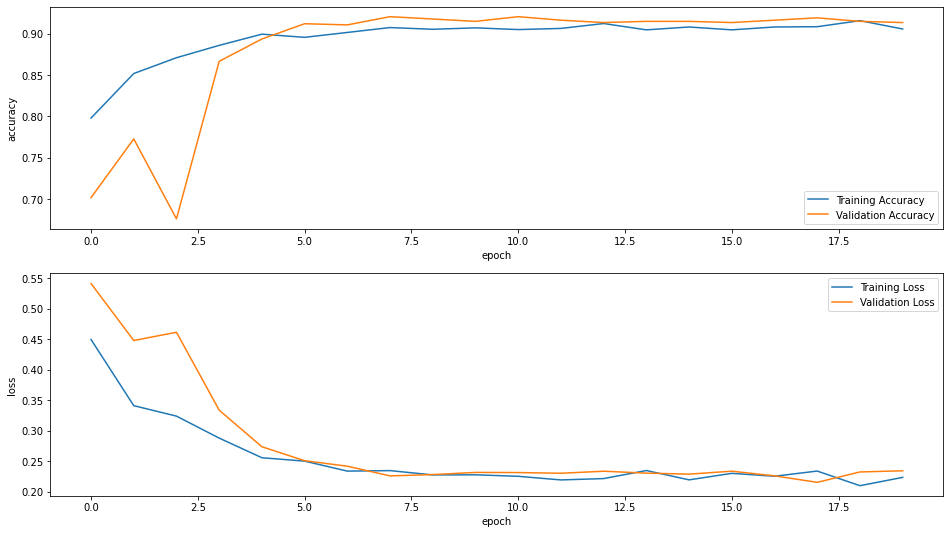

In [ ]:
acc = history_unbalanced.history['accuracy']
val_acc = history_unbalanced.history['val_accuracy']

loss = history_unbalanced.history['loss']
val_loss = history_unbalanced.history['val_loss']

epochs_range = range(20)

fig, axes = plt.subplots(2, 1, figsize=(16,9))

axes[0].plot(epochs_range, acc, label='Training Accuracy')
axes[0].plot(epochs_range, val_acc, label='Validation Accuracy')
axes[0].legend(loc='lower right')
axes[0].set_ylabel('accuracy')
axes[0].set_xlabel('epoch')

axes[1].plot(epochs_range, loss, label='Training Loss')
axes[1].plot(epochs_range, val_loss, label='Validation Loss')
axes[1].legend(loc='upper right')
axes[1].set_ylabel('loss')
axes[1].set_xlabel('epoch')

plt.show()


In [ ]:
evaluation = net.evaluate(X_base_test, y_base_test, verbose=0)
print(f'Test loss: {evaluation[0]} / Test accuracy: {evaluation[1]}')

Test loss: 0.22991596162319183 / Test accuracy: 0.9066666960716248


### Test over the part of the dataset without labels

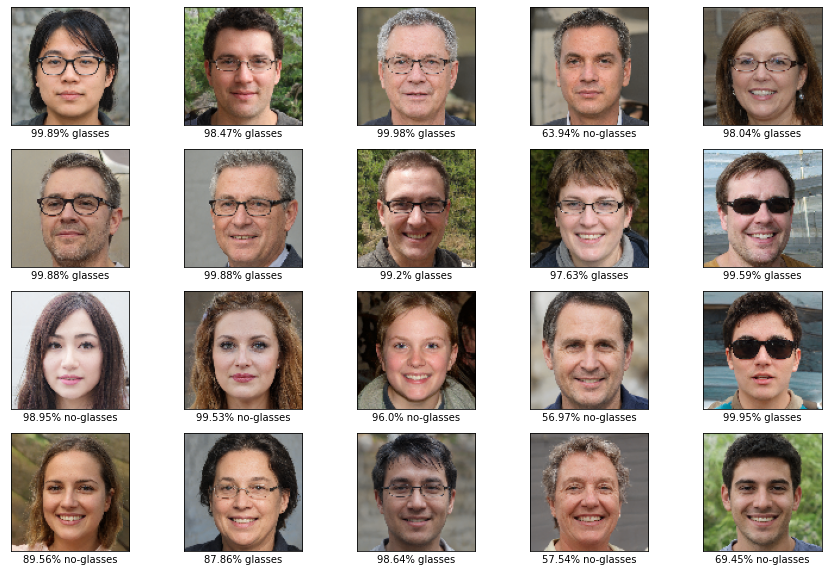

In [ ]:
predictions = net.predict(test_images)

plt.figure(figsize=(15,10))
for i in range(20):
  plt.subplot(4,5,i+1)
  plt.xticks([])
  plt.yticks([])
  plt.grid(False)
  plt.imshow(test_images[i])
  if predictions[i, 0] >= 0.5:
    plt.xlabel(f'{round(predictions[i][0]*100, ndigits=2)}% glasses')
  else:
    plt.xlabel(f'{round((1-predictions[i][0])*100, ndigits=2)}% no-glasses')
plt.show()

## 2.2 In this section we perform experiments on networks with different architectures for the balanced dataset

In [ ]:
X_aug, y_aug = divide_samples_labels(oversampled_train)

In [ ]:
X_balance_train, X_balance_test, y_balance_train, y_balance_test = train_test_split(X_aug, y_aug, test_size=0.2, random_state=seed)
X_balance_train, X_balance_validation, y_balance_train, y_balance_validation = train_test_split(X_balance_train, y_balance_train, test_size=0.2, random_state=seed)

ds_balance_train = get_dataset_for_CNN(X_balance_train, y_balance_train, batch_size)
ds_balance_validation = get_dataset_for_CNN(X_balance_validation, y_balance_validation, batch_size)
ds_balance_test = get_dataset_for_CNN(X_balance_test, y_balance_test, batch_size)

### Base Architecture

In [ ]:
def get_cnn_base(input_shape=input_shape):
    net = Sequential()
    net.add(Conv2D(16, 3, activation='relu', input_shape=input_shape))
    net.add(MaxPooling2D())
    net.add(Conv2D(32, 5, 2, activation='relu'))
    net.add(MaxPooling2D())

    net.add(Flatten())
    net.add(Dense(64, activation='relu'))
    net.add(Dense(1, activation='sigmoid'))

    net.compile(loss=tf.keras.losses.BinaryCrossentropy(), optimizer=tf.keras.optimizers.Adam(), metrics=['accuracy'])
    return net

In [ ]:
base_balance = get_cnn_base()

hist_base_balance = base_balance.fit(x=ds_balance_train,
              epochs=20,
              validation_data=ds_balance_validation,
              verbose=1, 
              callbacks=[lr_decay_callback])
hist_base_balance_evaluate = base_balance.evaluate(x=ds_balance_test)

Epoch 1/20
114/114 [==============================] - 2s 15ms/step - loss: 0.6999 - accuracy: 0.5855 - val_loss: 0.4652 - val_accuracy: 0.7612 - lr: 0.0100
Epoch 2/20
114/114 [==============================] - 2s 13ms/step - loss: 0.3705 - accuracy: 0.8336 - val_loss: 0.2881 - val_accuracy: 0.8862 - lr: 0.0060
Epoch 3/20
114/114 [==============================] - 2s 13ms/step - loss: 0.2773 - accuracy: 0.8898 - val_loss: 0.2770 - val_accuracy: 0.8783 - lr: 0.0036
Epoch 4/20
114/114 [==============================] - 2s 13ms/step - loss: 0.2420 - accuracy: 0.9038 - val_loss: 0.2505 - val_accuracy: 0.9062 - lr: 0.0022
Epoch 5/20
114/114 [==============================] - 2s 13ms/step - loss: 0.2203 - accuracy: 0.9120 - val_loss: 0.2491 - val_accuracy: 0.9007 - lr: 0.0013
Epoch 6/20
114/114 [==============================] - 2s 13ms/step - loss: 0.2079 - accuracy: 0.9137 - val_loss: 0.2405 - val_accuracy: 0.8973 - lr: 7.7760e-04
Epoch 7/20
114/114 [==============================] - 2s 13m

### Double Convolutional layers Architecture


In [ ]:
def get_cnn_double_conv(input_shape=input_shape):
    net = Sequential()

    net.add(Conv2D(16, 3, input_shape=input_shape))
    net.add(Activation('relu'))
    net.add(Conv2D(16, 3, ))
    net.add(Activation('relu'))
    net.add(MaxPooling2D((2,2), strides=(2,2)))

    net.add(Conv2D(32, 5, 2))
    net.add(Activation('relu'))
    net.add(Conv2D(32, 5, 2))
    net.add(Activation('relu'))
    net.add(Conv2D(32, 5, 2))
    net.add(Activation('relu'))
    net.add(MaxPooling2D((2,2), strides=(2,2)))

    net.add(Flatten())
    net.add(Dense(64))
    net.add(Activation('relu'))
    net.add(Dropout(0.5))
    net.add(Dense(64))
    net.add(Activation('relu'))
    net.add(Dropout(0.5))
    net.add(Dense(1, activation='sigmoid'))

    net.compile(loss=tf.keras.losses.BinaryCrossentropy(), optimizer=tf.keras.optimizers.Adam(), metrics=['accuracy'])
    return net

In [ ]:
double_conv_balance = get_cnn_double_conv()
hist_double_conv_balance = double_conv_balance.fit(x=ds_balance_train,
              epochs=20,
              validation_data=ds_balance_validation,
              verbose=1,
              callbacks=[lr_decay_callback])
hist_double_conv_balance_evaluate = double_conv_balance.evaluate(x=ds_balance_test)

Epoch 1/20
114/114 [==============================] - 5s 32ms/step - loss: 0.7766 - accuracy: 0.5071 - val_loss: 0.6936 - val_accuracy: 0.5134 - lr: 0.0100
Epoch 2/20
114/114 [==============================] - 3s 29ms/step - loss: 0.6944 - accuracy: 0.5112 - val_loss: 0.6950 - val_accuracy: 0.4888 - lr: 0.0060
Epoch 3/20
114/114 [==============================] - 3s 29ms/step - loss: 0.6934 - accuracy: 0.5063 - val_loss: 0.6930 - val_accuracy: 0.5145 - lr: 0.0036
Epoch 4/20
114/114 [==============================] - 3s 29ms/step - loss: 0.6931 - accuracy: 0.5189 - val_loss: 0.6932 - val_accuracy: 0.4900 - lr: 0.0022
Epoch 5/20
114/114 [==============================] - 3s 29ms/step - loss: 0.6934 - accuracy: 0.5066 - val_loss: 0.6931 - val_accuracy: 0.5112 - lr: 0.0013
Epoch 6/20
114/114 [==============================] - 3s 29ms/step - loss: 0.6934 - accuracy: 0.5000 - val_loss: 0.6931 - val_accuracy: 0.5112 - lr: 7.7760e-04
Epoch 7/20
114/114 [==============================] - 3s 29m

### Batch Normalization and Dropout Achitecture

In [ ]:
def get_cnn_batch_norm(input_shape=(100,100,3)):
    net = Sequential()
    
    net.add(Conv2D(16, kernel_size=3, padding='same', input_shape=input_shape))
    net.add(BatchNormalization(center=True, scale=False))
    net.add(Activation('relu'))
    net.add(Conv2D(16, kernel_size=3, padding='same'))
    net.add(BatchNormalization(center=True, scale=False))
    net.add(Activation('relu'))
    net.add(MaxPooling2D())

    net.add(Conv2D(32, kernel_size=5, padding='same', strides=2))
    net.add(BatchNormalization(center=True, scale=False))
    net.add(Activation('relu'))
    net.add(Conv2D(32, kernel_size=5, padding='same', strides=2))
    net.add(BatchNormalization(center=True, scale=False))
    net.add(Activation('relu'))
    net.add(MaxPooling2D())

    net.add(Flatten())
    net.add(Dense(64))
    net.add(BatchNormalization(center=True, scale=False))
    net.add(Activation('relu'))
    net.add(Dropout(0.5))
    net.add(Dense(1))
    net.add(Activation('sigmoid'))

    net.compile(loss=tf.keras.losses.BinaryCrossentropy(), optimizer=tf.keras.optimizers.Adam(), metrics=['accuracy'])
    return net

In [ ]:
batch_norm_balance = get_cnn_batch_norm()
hist_batch_norm_balance = batch_norm_balance.fit(x=ds_balance_train,
              epochs=20,
              validation_data=ds_balance_validation,
              verbose=1, 
              callbacks=[lr_decay_callback])
hist_batch_norm_balance_evaluate = batch_norm_balance.evaluate(x=ds_balance_test)

Epoch 1/20
114/114 [==============================] - 6s 44ms/step - loss: 0.3336 - accuracy: 0.8607 - val_loss: 1.8939 - val_accuracy: 0.4833 - lr: 0.0100
Epoch 2/20
114/114 [==============================] - 4s 38ms/step - loss: 0.2613 - accuracy: 0.9008 - val_loss: 1.9288 - val_accuracy: 0.4888 - lr: 0.0060
Epoch 3/20
114/114 [==============================] - 4s 38ms/step - loss: 0.2194 - accuracy: 0.9104 - val_loss: 0.2298 - val_accuracy: 0.9118 - lr: 0.0036
Epoch 4/20
114/114 [==============================] - 4s 38ms/step - loss: 0.1975 - accuracy: 0.9232 - val_loss: 0.4027 - val_accuracy: 0.8203 - lr: 0.0022
Epoch 5/20
114/114 [==============================] - 4s 38ms/step - loss: 0.1757 - accuracy: 0.9276 - val_loss: 0.3412 - val_accuracy: 0.8850 - lr: 0.0013
Epoch 6/20
114/114 [==============================] - 4s 38ms/step - loss: 0.1507 - accuracy: 0.9413 - val_loss: 0.2410 - val_accuracy: 0.9185 - lr: 7.7760e-04
Epoch 7/20
114/114 [==============================] - 4s 38m

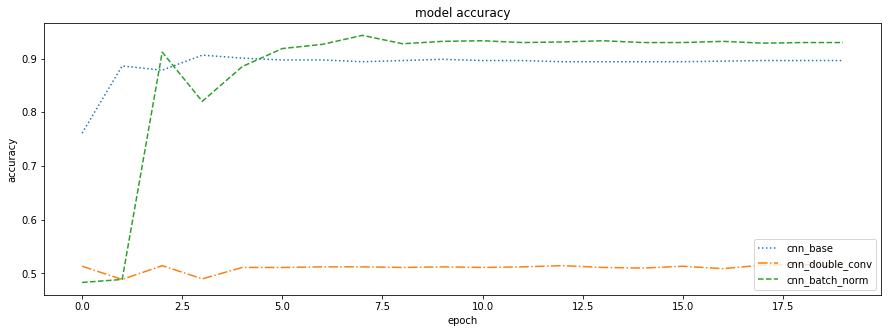

In [ ]:
names = ["cnn_base","cnn_double_conv","cnn_batch_norm"]
styles=[':','-.','--','-']

plt.figure(figsize=(15,5))
plt.plot(hist_base_balance.history['val_accuracy'], linestyle=styles[0])
plt.plot(hist_double_conv_balance.history['val_accuracy'], linestyle=styles[1])
plt.plot(hist_batch_norm_balance.history['val_accuracy'], linestyle=styles[2])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(names, loc='lower right')
plt.show()

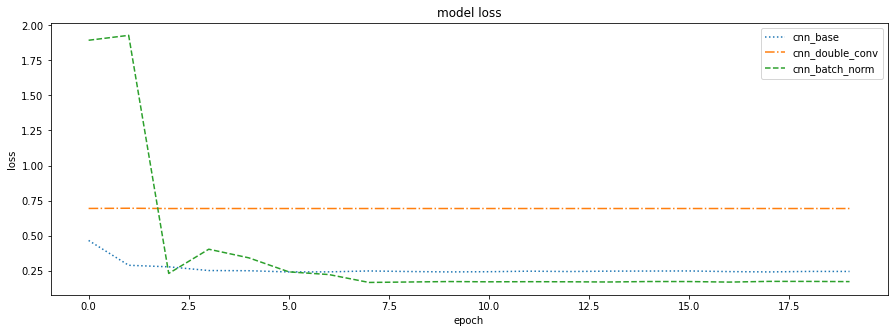

In [ ]:
names = ["cnn_base","cnn_double_conv","cnn_batch_norm"]
styles=[':','-.','--','-']


plt.figure(figsize=(15,5))
plt.plot(hist_base_balance.history['val_loss'], linestyle=styles[0])
plt.plot(hist_double_conv_balance.history['val_loss'], linestyle=styles[1])
plt.plot(hist_batch_norm_balance.history['val_loss'], linestyle=styles[2])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(names, loc='upper right')
plt.show()

## Parameters tuning with stratified cross validation for balanced dataset

### Let's see how many blocks we need

In [ ]:
conv_layer = [1, 2, 3]

scores_net_layers_balanced = {}
for l in conv_layer:
  print(f"> CV {l} layer")
  scores_net_layers_balanced[l] = stratifiedCV(X_aug, y_aug, blocks=l)

for i in scores_net_layers_balanced:
  print(f"Layers {i} layers:")
  print_results(scores_net_layers_balanced[i])

> CV 1 layer
Training for fold 1
60/60 [==============================] - 1s 11ms/step - loss: 0.1929 - accuracy: 0.9265
Score for fold 1: loss of 0.19294294714927673; accuracy of 92.64705777168274%
Training for fold 2
60/60 [==============================] - 1s 11ms/step - loss: 0.2269 - accuracy: 0.9144
Score for fold 2: loss of 0.2269390970468521; accuracy of 91.43907427787781%
Training for fold 3
60/60 [==============================] - 1s 11ms/step - loss: 0.2006 - accuracy: 0.9296
Score for fold 3: loss of 0.20057187974452972; accuracy of 92.96218752861023%
> CV 2 layer
Training for fold 1
60/60 [==============================] - 1s 16ms/step - loss: 0.2152 - accuracy: 0.9181
Score for fold 1: loss of 0.21519321203231812; accuracy of 91.8067216873169%
Training for fold 2
60/60 [==============================] - 1s 12ms/step - loss: 0.2409 - accuracy: 0.9102
Score for fold 2: loss of 0.24090830981731415; accuracy of 91.01890921592712%
Training for fold 3
60/60 [===================

### How many feature maps we need?

In [ ]:
conv_filters = [8, 16, 32]

scores_net_filters_balanced = {}
for filter in conv_filters:
  print(f"> Filters: {filter}")
  scores_net_filters_balanced[filter] = stratifiedCV(X_aug, y_aug, blocks=1, filters=filter)

for i in scores_net_filters_balanced:
  print(f"Filters {i}:")
  print_results(scores_net_filters_balanced[i])

> Filters: 8
Training for fold 1
60/60 [==============================] - 1s 10ms/step - loss: 0.1930 - accuracy: 0.9265
Score for fold 1: loss of 0.19302253425121307; accuracy of 92.64705777168274%
Training for fold 2
60/60 [==============================] - 1s 8ms/step - loss: 0.2349 - accuracy: 0.9118
Score for fold 2: loss of 0.23491881787776947; accuracy of 91.17646813392639%
Training for fold 3
60/60 [==============================] - 1s 9ms/step - loss: 0.1992 - accuracy: 0.9296
Score for fold 3: loss of 0.19921372830867767; accuracy of 92.96218752861023%
> Filters: 16
Training for fold 1
60/60 [==============================] - 1s 12ms/step - loss: 0.1976 - accuracy: 0.9275
Score for fold 1: loss of 0.19756175577640533; accuracy of 92.75209903717041%
Training for fold 2
60/60 [==============================] - 1s 11ms/step - loss: 0.2338 - accuracy: 0.9091
Score for fold 2: loss of 0.2337975800037384; accuracy of 90.91386795043945%
Training for fold 3
60/60 [===================

Then from the above experiements, it appears that 32 filters in the first convolutional layer and 1 block is the best architecture.

## Manual GridSearch

In [ ]:
def get_cnn_batch_norm_gridsearch_balance(conv_filters, blocks):
    net = Sequential()
    
    net.add(Conv2D(conv_filters, kernel_size=3, padding='same', input_shape=input_shape))
    net.add(BatchNormalization(center=True, scale=False))
    net.add(Activation('relu'))
    net.add(Conv2D(conv_filters, kernel_size=3, padding='same'))
    net.add(BatchNormalization(center=True, scale=False))
    net.add(Activation('relu'))
    net.add(MaxPooling2D())

    if blocks > 1:
      net.add(Conv2D(conv_filters*2, kernel_size=5, padding='same', strides=2))
      net.add(BatchNormalization(center=True, scale=False))
      net.add(Activation('relu'))
      net.add(Conv2D(conv_filters*2, kernel_size=5, padding='same', strides=2))
      net.add(BatchNormalization(center=True, scale=False))
      net.add(Activation('relu'))
      net.add(MaxPooling2D())
    
    if blocks > 2:
      net.add(Conv2D(conv_filters*3, kernel_size=5, padding='same', strides=2))
      net.add(BatchNormalization(center=True, scale=False))
      net.add(Activation('relu'))
      net.add(Conv2D(conv_filters*3, kernel_size=5, padding='same', strides=2))
      net.add(BatchNormalization(center=True, scale=False))
      net.add(Activation('relu'))
      net.add(MaxPooling2D())


    net.add(Flatten())
    net.add(Dense(64))
    net.add(BatchNormalization(center=True, scale=False))
    net.add(Activation('relu'))
    net.add(Dropout(0.5))
    net.add(Dense(1))
    net.add(Activation('sigmoid'))

    net.compile(loss=tf.keras.losses.BinaryCrossentropy(), optimizer=tf.keras.optimizers.Adam(), metrics=['accuracy'])
    return net

In [ ]:
skf3 = StratifiedKFold(shuffle=True, random_state=seed, n_splits=3)

def stratifiedCV_grid_search_balance(X, Y, blocks=2, filters=16,
                 input_shape=(100, 100, 3), skf = skf3, epochs=20):
  scores = []
  acc_per_fold = []
  loss_per_fold = []
  fold_no = 1
  for train_index, test_index in skf.split(X, Y):
    print(f'Training for fold {fold_no}')
    net = get_cnn_batch_norm_gridsearch_balance(filters, blocks)
    dataset = get_dataset_for_CNN(X[train_index], Y[train_index], batch_size)
    history = net.fit(x=dataset,
              callbacks=[lr_decay_callback],
              epochs=epochs, 
              verbose=0)
    score = net.evaluate(X[test_index], Y[test_index], verbose=1)
    
    print(f'Score for fold {fold_no}: {net.metrics_names[0]} of {score[0]}; {net.metrics_names[1]} of {score[1]*100}%')
    acc_per_fold.append(score[1] * 100)
    loss_per_fold.append(score[0])
    fold_no = fold_no + 1
      
    scores.append(score)
  return (scores, loss_per_fold, acc_per_fold)

In [ ]:
import time 

conv_filters = [8, 16, 32]
conv_layer = [1, 2, 3]

scores_grid_search_balanced = {}
for layer_size in conv_filters:
  print(f"> Filters: {layer_size}")
  for block in conv_layer:
    print(f"> Blocks: {block}")
    NAME = "{}-filters-{}-blocks-{}".format(layer_size, block, int(time.time()))
    scores_grid_search_balanced[NAME] =  stratifiedCV_grid_search_balance(X_aug, y_aug, blocks=block, filters=layer_size)

for i in scores_grid_search_balanced:
  print(f"Scores for {i}:")
  print_results(scores_grid_search_balanced[i])

> Filters: 8
> Blocks: 1
Training for fold 1
60/60 [==============================] - 1s 9ms/step - loss: 0.2036 - accuracy: 0.9223
Score for fold 1: loss of 0.20358999073505402; accuracy of 92.22689270973206%
Training for fold 2
60/60 [==============================] - 1s 9ms/step - loss: 0.2376 - accuracy: 0.9118
Score for fold 2: loss of 0.2375897914171219; accuracy of 91.17646813392639%
Training for fold 3
60/60 [==============================] - 1s 9ms/step - loss: 0.2054 - accuracy: 0.9280
Score for fold 3: loss of 0.2054232954978943; accuracy of 92.80462265014648%
> Blocks: 2
Training for fold 1
60/60 [==============================] - 1s 10ms/step - loss: 0.2343 - accuracy: 0.9207
Score for fold 1: loss of 0.23427575826644897; accuracy of 92.06932783126831%
Training for fold 2
60/60 [==============================] - 1s 10ms/step - loss: 0.2469 - accuracy: 0.9112
Score for fold 2: loss of 0.24686698615550995; accuracy of 91.1239504814148%
Training for fold 3
60/60 [============

From the above experiments the best configuration is composed by 1 block and 32 filters in the convolutional layer.

Average scores for all folds:
- Accuracy: 92.27941036224365 (+- 0.4945522462571664)
- Loss: 0.20618596176306406

### How many neurons?


In [ ]:
dense = [32, 64, 128]

scores_net_dense_balanced = {}
for neurons in dense:
  print(f"> Neurons: {neurons}")
  scores_net_dense_balanced[neurons] = stratifiedCV(X_aug, y_aug, blocks=1, filters=32, neurons=neurons)

for i in scores_net_dense_balanced:
  print(f"Scores for {i} neurons:")
  print_results(scores_net_dense_balanced[i])

> Neurons: 32
Training for fold 1
60/60 [==============================] - 1s 15ms/step - loss: 0.1929 - accuracy: 0.9270
Score for fold 1: loss of 0.19293968379497528; accuracy of 92.69958138465881%
Training for fold 2
60/60 [==============================] - 1s 15ms/step - loss: 0.2261 - accuracy: 0.9128
Score for fold 2: loss of 0.22612334787845612; accuracy of 91.28151535987854%
Training for fold 3
60/60 [==============================] - 1s 15ms/step - loss: 0.2021 - accuracy: 0.9238
Score for fold 3: loss of 0.20207259058952332; accuracy of 92.38445162773132%
> Neurons: 64
Training for fold 1
60/60 [==============================] - 1s 15ms/step - loss: 0.1948 - accuracy: 0.9270
Score for fold 1: loss of 0.1948324292898178; accuracy of 92.69958138465881%
Training for fold 2
60/60 [==============================] - 1s 15ms/step - loss: 0.2221 - accuracy: 0.9196
Score for fold 2: loss of 0.22211764752864838; accuracy of 91.96428656578064%
Training for fold 3
60/60 [================

The best CNN architecture seems to be composed by one block, 32 filters in the first convolutional layer and 64 neurons in the fully connected layer.

### And what about dropout?

In [ ]:
dropout = [0.3, 0.5, 0.7]

scores_net_dropout_balanced = {}
for do in dropout:
  print(f"> Dropout: {do}")
  scores_net_dropout_balanced[do] = stratifiedCV(X_aug, y_aug, blocks=1, filters=32, neurons=64, dropout=do)

for i in scores_net_dropout_balanced:
  print(f"Scores for {i} dropout:")
  print_results(scores_net_dropout_balanced[i])

> Dropout: 0.3
Training for fold 1
60/60 [==============================] - 1s 15ms/step - loss: 0.2109 - accuracy: 0.9217
Score for fold 1: loss of 0.2108711302280426; accuracy of 92.17436909675598%
Training for fold 2
60/60 [==============================] - 1s 15ms/step - loss: 0.2322 - accuracy: 0.9139
Score for fold 2: loss of 0.23217707872390747; accuracy of 91.38655662536621%
Training for fold 3
60/60 [==============================] - 1s 14ms/step - loss: 0.2023 - accuracy: 0.9270
Score for fold 3: loss of 0.20227842032909393; accuracy of 92.69958138465881%
> Dropout: 0.5
Training for fold 1
60/60 [==============================] - 1s 15ms/step - loss: 0.1924 - accuracy: 0.9259
Score for fold 1: loss of 0.19239988923072815; accuracy of 92.59454011917114%
Training for fold 2
60/60 [==============================] - 1s 15ms/step - loss: 0.2325 - accuracy: 0.9123
Score for fold 2: loss of 0.23250874876976013; accuracy of 91.22899174690247%
Training for fold 3
60/60 [==============

The best CNN result to be composed by one block, 32 filters in the first convolutional layer and 64 neurons in the fully connected layer with a dropout of 0.7

## Evaluate CNN for balanced dataset

## Training the best found CNN

In [ ]:
net_balanced = get_cnn_batch_norm_CV(input_shape=input_shape, conv_filters=32, neurons=64, blocks=1, dropout=0.7)
history_balanced = net_balanced.fit(x=ds_balance_train,
              epochs=20,
              validation_data=ds_balance_validation,
              verbose=1, 
              callbacks=[lr_decay_callback])

Epoch 1/20
114/114 [==============================] - 7s 48ms/step - loss: 0.3699 - accuracy: 0.8490 - val_loss: 1.4837 - val_accuracy: 0.4877 - lr: 0.0100
Epoch 2/20
114/114 [==============================] - 5s 47ms/step - loss: 0.2717 - accuracy: 0.8934 - val_loss: 2.2192 - val_accuracy: 0.4855 - lr: 0.0060
Epoch 3/20
114/114 [==============================] - 5s 46ms/step - loss: 0.2402 - accuracy: 0.8986 - val_loss: 1.2185 - val_accuracy: 0.4967 - lr: 0.0036
Epoch 4/20
114/114 [==============================] - 5s 46ms/step - loss: 0.2136 - accuracy: 0.9158 - val_loss: 0.3710 - val_accuracy: 0.8504 - lr: 0.0022
Epoch 5/20
114/114 [==============================] - 5s 46ms/step - loss: 0.1979 - accuracy: 0.9254 - val_loss: 0.2427 - val_accuracy: 0.9040 - lr: 0.0013
Epoch 6/20
114/114 [==============================] - 5s 46ms/step - loss: 0.1847 - accuracy: 0.9285 - val_loss: 0.2411 - val_accuracy: 0.9085 - lr: 7.7760e-04
Epoch 7/20
114/114 [==============================] - 5s 46m

### Plotting validation results

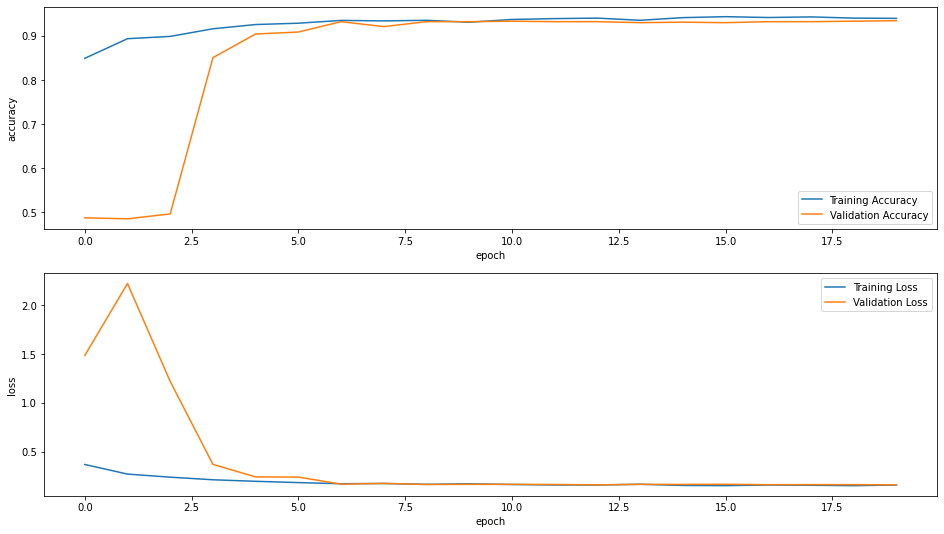

In [ ]:
acc = history_balanced.history['accuracy']
val_acc = history_balanced.history['val_accuracy']

loss = history_balanced.history['loss']
val_loss = history_balanced.history['val_loss']

epochs_range = range(20)

fig, axes = plt.subplots(2, 1, figsize=(16,9))

axes[0].plot(epochs_range, acc, label='Training Accuracy')
axes[0].plot(epochs_range, val_acc, label='Validation Accuracy')
axes[0].legend(loc='lower right')
axes[0].set_ylabel('accuracy')
axes[0].set_xlabel('epoch')

axes[1].plot(epochs_range, loss, label='Training Loss')
axes[1].plot(epochs_range, val_loss, label='Validation Loss')
axes[1].legend(loc='upper right')
axes[1].set_ylabel('loss')
axes[1].set_xlabel('epoch')

plt.show()

In [ ]:
evaluation = net_balanced.evaluate(X_balance_test, y_balance_test, verbose=0)
print(f'Test loss: {evaluation[0]} / Test accuracy: {evaluation[1]}')

Test loss: 0.2224494069814682 / Test accuracy: 0.913385808467865


### Test over the part of the dataset without labels

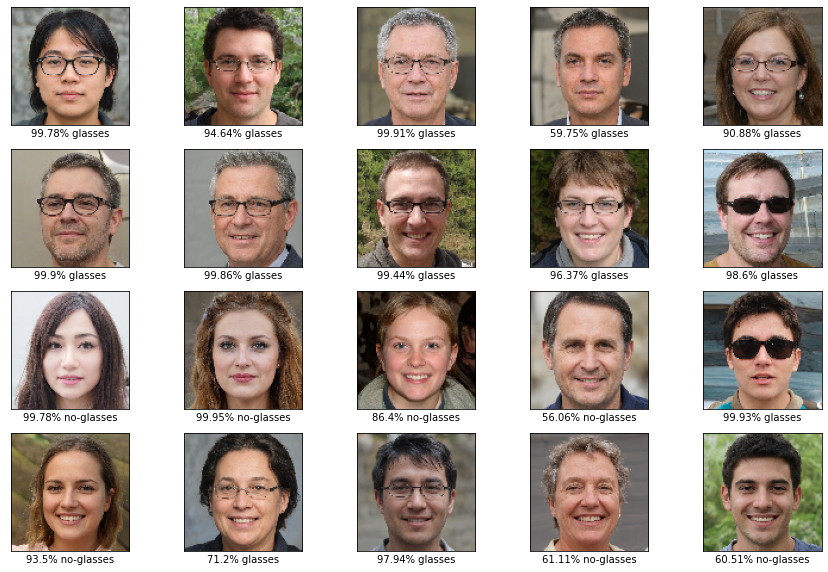

In [ ]:
predictions = net_balanced.predict(test_images)

plt.figure(figsize=(15,10))
for i in range(20):
  plt.subplot(4,5,i+1)
  plt.xticks([])
  plt.yticks([])
  plt.grid(False)
  plt.imshow(test_images[i])
  if predictions[i, 0] >= 0.5:
    plt.xlabel(f'{round(predictions[i][0]*100, ndigits=2)}% glasses')
  else:
    plt.xlabel(f'{round((1-predictions[i][0])*100, ndigits=2)}% no-glasses')
plt.show()